Шенцов Данил

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm

In [2]:
#Настроим вывод всех строк для удобства анализа
pd.set_option('display.max_rows', None)

In [3]:
#Загрузим файл
df = pd.read_csv('income_train.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,37,Self-emp-not-inc,112497,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
1,39,Private,278557,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1628,48,United-States,<=50K
2,33,Private,173858,Bachelors,13,Married-civ-spouse,Adm-clerical,Other-relative,Asian-Pac-Islander,Male,0,0,40,India,<=50K
3,35,?,120074,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,30,United-States,<=50K
4,21,Private,199915,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K


In [4]:
#Анализируем данные
display(df.isna().sum())
display(df.isin(['?']).sum())
display(df['workclass'].value_counts(sort = True, ascending = False))
display(df['occupation'].value_counts(sort = True, ascending = False))
display(df['native-country'].value_counts(sort = True, ascending = False))
display(df['marital-status'].value_counts(sort = True, ascending = False))
display(df['relationship'].value_counts(sort = True, ascending = False))

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

age                  0
workclass         1501
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1506
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     468
income               0
dtype: int64

Private             18162
Self-emp-not-inc     2019
Local-gov            1683
?                    1501
State-gov            1031
Self-emp-inc          895
Federal-gov           744
Without-pay             8
Never-worked            5
Name: workclass, dtype: int64

Prof-specialty       3330
Craft-repair         3264
Exec-managerial      3250
Adm-clerical         3039
Sales                2913
Other-service        2610
Machine-op-inspct    1590
?                    1506
Transport-moving     1289
Handlers-cleaners    1093
Farming-fishing       769
Tech-support          742
Protective-serv       531
Priv-house-serv       116
Armed-Forces            6
Name: occupation, dtype: int64

United-States                 23306
Mexico                          506
?                               468
Philippines                     172
Germany                         114
Canada                           97
Puerto-Rico                      88
India                            83
El-Salvador                      81
Cuba                             75
Jamaica                          71
England                          70
South                            65
Italy                            65
China                            60
Japan                            57
Dominican-Republic               54
Vietnam                          53
Guatemala                        52
Columbia                         50
Poland                           48
Taiwan                           40
Iran                             36
Haiti                            30
Nicaragua                        28
Peru                             27
Greece                           26
Portugal                    

Married-civ-spouse       11992
Never-married             8522
Divorced                  3571
Widowed                    802
Separated                  792
Married-spouse-absent      353
Married-AF-spouse           16
Name: marital-status, dtype: int64

Husband           10556
Not-in-family      6563
Own-child          4085
Unmarried          2788
Wife               1263
Other-relative      793
Name: relationship, dtype: int64

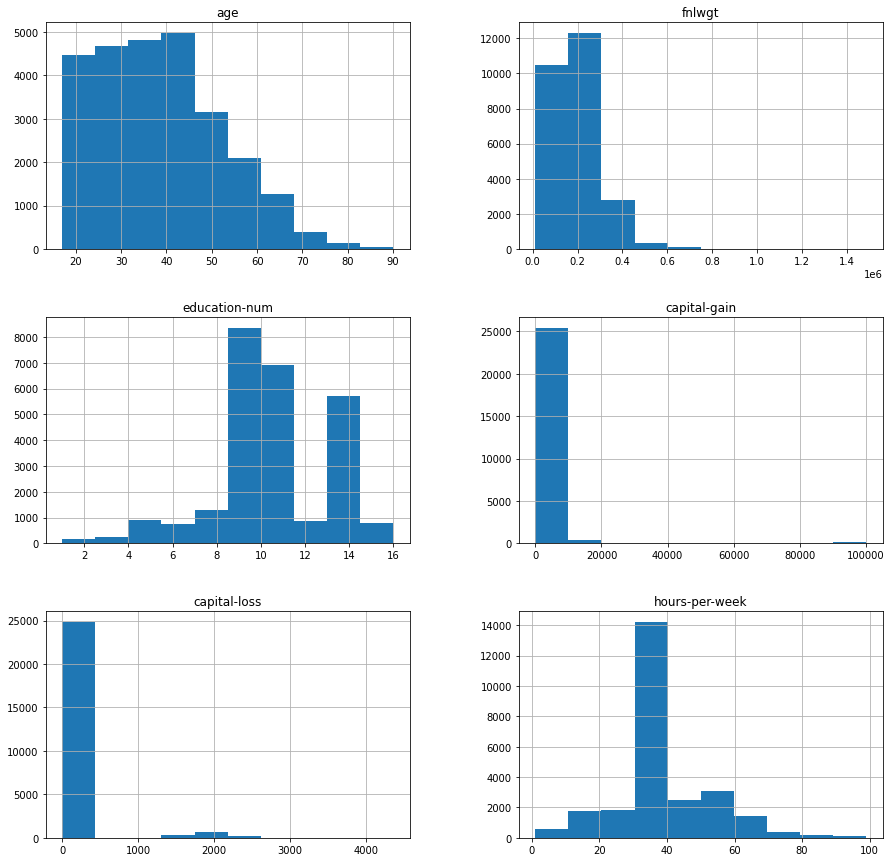

In [5]:
df.hist(figsize=(15, 15));

In [6]:
#Перекодируем категории результирующего столбика
df.income.replace('<=50K', 0, inplace = True)
df.income.replace('>50K', 1, inplace = True)
df.income.value_counts()

0    19751
1     6297
Name: income, dtype: int64

In [7]:
#Перекодируем семейное положение в более адекватные категории
marital_dict = {'Married-AF-spouse': 'Married',
               'Married-civ-spouse': 'Married',
               'Married-spouse-absent': 'Alone',
               'Divorced': 'Not-Married',
               'Separated': 'Not-Married',
               'Widowed': 'Alone',
                'Never-married': 'Never-married'
               }
df['marital-status'] = df['marital-status'].map(marital_dict)
df.head(3)
#Проверим теперь
display(df['marital-status'].value_counts())

Married          12008
Never-married     8522
Not-Married       4363
Alone             1155
Name: marital-status, dtype: int64

In [8]:
#Проанализируем две категории рабочего класса
display(df[(df.workclass != '?') & (df.occupation == '?')])
display(df[(df.workclass == 'Without-pay')])

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
6408,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,0
10129,30,Never-worked,176673,HS-grad,9,Married,?,Wife,Black,Female,0,0,40,United-States,0
12174,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
18480,18,Never-worked,157131,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,0
21763,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,0


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
777,68,Without-pay,174695,Some-college,10,Alone,Farming-fishing,Unmarried,White,Female,0,0,25,United-States,0
5739,46,Without-pay,142210,HS-grad,9,Married,Machine-op-inspct,Wife,White,Female,0,0,25,United-States,0
9765,62,Without-pay,159908,Some-college,10,Married,Adm-clerical,Wife,White,Female,0,0,16,United-States,0
14463,65,Without-pay,27012,7th-8th,4,Alone,Farming-fishing,Unmarried,White,Female,0,0,50,United-States,0
16392,29,Without-pay,212588,Some-college,10,Married,Farming-fishing,Own-child,White,Male,0,0,65,United-States,0
17763,52,Without-pay,198262,HS-grad,9,Married,Adm-clerical,Wife,White,Female,0,0,30,United-States,0
18713,19,Without-pay,344858,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,20,United-States,0
19971,62,Without-pay,170114,Assoc-acdm,12,Married,Farming-fishing,Husband,White,Male,0,0,50,United-States,0


In [9]:
#Добавляем новую категорию unemployed, у всех у них доходы ниже 50К
df.loc[df.workclass == 'Without-pay', 'occupation'] = 'Unemployed'
df.loc[df.workclass == 'Never-worked', 'occupation'] = 'Unemployed'

In [10]:
#Обследуем данные пропущенные с гипотезой, что ? - по большей части безработные
display(df['income'].value_counts())
display(df[df.workclass == '?']['income'].value_counts())
display(df.groupby('workclass')['income'].agg('mean'))

0    19751
1     6297
Name: income, dtype: int64

0    1340
1     161
Name: income, dtype: int64

workclass
?                   0.107262
Federal-gov         0.375000
Local-gov           0.297089
Never-worked        0.000000
Private             0.220570
Self-emp-inc        0.560894
Self-emp-not-inc    0.287766
State-gov           0.259942
Without-pay         0.000000
Name: income, dtype: float64

In [11]:
#Присваиваем категорию Unemployed, потому что при среднем 33% для генеральной совокупности, 
#для нашей выборки только 11% имеют доход выше 50К
df.loc[df.workclass == '?', 'occupation'] = 'Unemployed'

In [12]:
#Проанализируем доходы по странам происхождения граждан
df.groupby('native-country').income.agg(['mean', 'count']).sort_values('mean')

,mean,count
native-country,,
Outlying-US(Guam-USVI-etc),0.000000,9
Honduras,0.000000,10
Holand-Netherlands,0.000000,1
Dominican-Republic,0.018519,54
Nicaragua,0.035714,28
Guatemala,0.038462,52
Columbia,0.040000,50
Mexico,0.059289,506
Laos,0.066667,15


In [13]:
#Создаём список стран, где номер переменной означает вероятность получения высоких доходов на основе страны
#Существует определённый риск с непрезентативностью выборки по некоторым странам, представителей которых мало
country_dict = {'Outlying-US(Guam-USVI-etc)': 0,
                'Dominican-Republic':0,
                'Holand-Netherlands':0,
                'Honduras': 0,
                'Guatemala': 0,
                'Nicaragua': 0,
                'Columbia': 0,
                'Mexico': 0,
                'Laos': 0,
                'Haiti': 0,
                'Peru': 0,
                'Puerto-Rico': 0,
                'Vietnam': 0,
                'El-Salvador': 0,
                'Portugal': 1,
                'Trinadad&Tobago': 1,
                'Thailand': 1,
                'Jamaica': 1,
                'Ireland': 1,
                'Ecuador': 1,
                '?': 2,
                'Hungary': 2,
                'South': 2,
                'China': 2,
                'United-States': 2,
                'Poland': 2,
                'Cuba': 2,
                'Scotland': 2,
                'Greece': 3,
                'Hong': 3,
                'Philippines': 3,
                'Canada': 3,
                'Germany': 3,
                'Italy': 3,
                'England': 3,
                'India': 4,
                'Cambodia': 4,
                'Taiwan': 4,
                'Yugoslavia': 4,
                'Iran': 4,
                'Japan': 4,
                'France': 4}
df['native-country'] = df['native-country'].map(country_dict)

In [14]:
#Проверим корректное присваивание
display(df['native-country'].value_counts().sort_index())
display(df.isna().sum())

0     1004
1      171
2    24042
3      560
4      271
Name: native-country, dtype: int64

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [15]:
#Анализируем доход по расам
df.groupby('race')['income'].agg('mean')

race
Amer-Indian-Eskimo    0.100775
Asian-Pac-Islander    0.269231
Black                 0.122694
Other                 0.105528
White                 0.256891
Name: income, dtype: float64

In [16]:
#Создаём словарь по расам и проверяем корректное присвоение
racist_dict = {'Amer-Indian-Eskimo':0,
             'Black':0,
             'Other':0,
             'White':1,
             'Asian-Pac-Islander':1}
df['race'] = df['race'].map(racist_dict)
df['race'].value_counts().sort_index()

0     2951
1    23097
Name: race, dtype: int64

<AxesSubplot:>

<AxesSubplot:>

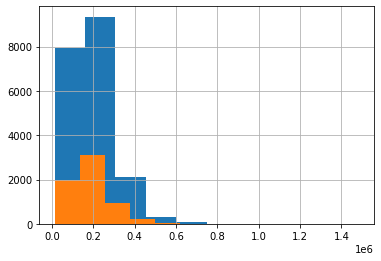

In [17]:
#Проанализируем столбик fnlwgt
display(df[df.income == 0]['fnlwgt'].hist())
display(df[df.income == 1]['fnlwgt'].hist())

In [18]:
#Колонка fnlwgt значима, а education содержит аналогичные данные, что и education-num
df.drop(columns = ['education'], inplace = True)
df.head(3)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,37,Self-emp-not-inc,112497,14,Married,Exec-managerial,Husband,1,Male,0,0,50,2,1
1,39,Private,278557,11,Married,Craft-repair,Husband,1,Male,0,1628,48,2,0
2,33,Private,173858,13,Married,Adm-clerical,Other-relative,1,Male,0,0,40,4,0


In [19]:
display(df.groupby('relationship')['income'].agg('mean'))
display(df.groupby('marital-status')['income'].agg('mean'))
#Видим неоднородность данных, колонка relationship даёт дополнительные сведения о детях, 
#единственное, что мы можем обобщить - муж и жена зарабатывают много, но это всё, поэтому изменений вводить не будем

relationship
Husband           0.449981
Not-in-family     0.103764
Other-relative    0.035309
Own-child         0.013464
Unmarried         0.068508
Wife              0.468725
Name: income, dtype: float64

marital-status
Alone            0.083983
Married          0.447618
Never-married    0.046585
Not-Married      0.098098
Name: income, dtype: float64

Закончили маппинг, приступаем к перекодировке X_train

In [20]:
#Сплит данных
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [21]:
#Трансформатор колонок
poly_transformer = Pipeline(steps=[('scaler', MinMaxScaler()), ('polynom', PolynomialFeatures(2, include_bias = False))])
enc_features = ['workclass','marital-status', 'occupation', 'relationship', 'sex'] #onehot
poly_features = ['age', 'education-num'] #полином
num_features = ['capital-gain', 'capital-loss', 'native-country','hours-per-week'] #scaler
CT = ColumnTransformer([
    ('num', Normalizer(), num_features),
    ('enc', OneHotEncoder(handle_unknown = 'ignore'), enc_features),
    ('pol', poly_transformer, poly_features)
 
])

res_ct = CT.fit_transform(X_train)

#res_ct[:1]

In [22]:
#Перекодируем тестовый x
res_test = CT.transform(X_test)
res_test[:1]

array([[0.        , 0.        , 0.04993762, 0.99875234, 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.47945205, 0.6       , 0.22987427, 0.28767123, 0.36      ]])

In [23]:
#Ридж-модель
#Оценивать здесь и далее будем по метрике balanced accuracy, поскольку имеем дело и имбалансными данными
ridge = RidgeClassifier()
ridge.fit(res_ct, y_train)
y_pred = ridge.predict(res_test)
print(balanced_accuracy_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Результаты в целом хорошие

0.7358160653351812
0.8388995521433141
[[5543  383]
 [ 876 1013]]


In [26]:
#Модель logreg. Точность выше. logreg модель с эластик нет выдаёт такие же показатели (модель в комменте)
#logreg = LogisticRegression(max_iter = 100000, penalty='elasticnet', solver = 'saga', l1_ratio = 0.6)
logreg = LogisticRegression(max_iter = 100000, solver = 'newton-cg')
logreg.fit(res_ct, y_train)
y_pred2 = logreg.predict(res_test)
print(balanced_accuracy_score(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))
print(roc_auc_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

0.7569001271549749
0.8451695457453615
0.7569001271549749
[[5498  428]
 [ 782 1107]]


In [25]:
#сетка для logreg модели
cv=ShuffleSplit(n_splits=5,  test_size=0.3)
param_grid =[
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'penalty': ['l1', 'l2']
     }
]

grid = GridSearchCV(logreg, param_grid, cv=cv, scoring = 'balanced_accuracy',  return_train_score=True, error_score=0.0)
grid.fit(res_ct,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid.best_params_))
print("Лучший результат на кроссвалидации: {:.4f}\n".format(grid.best_score_))
print("Тестовый: {:.4f}".format(grid.score(res_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

c:\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solve

Словарь с параметрами для лучшего решения:
{'penalty': 'l1', 'solver': 'saga'}

Лучший результат на кроссвалидации: 0.7608

Тестовый: 0.7549


,4,2,5,6,8,9,7,0,1,3
mean_fit_time,3.654517,4.588553,2.146041,1.280323,0.910229,2.41732,0.471519,0.016004,0.033608,0.009404
std_fit_time,0.956834,0.543569,0.712956,0.269337,0.142779,0.310787,0.065684,0.001416,0.026761,0.001021
mean_score_time,0.008203,0.005201,0.005804,0.009806,0.006202,0.006002,0.013603,0.0,0.0,0.0
std_score_time,0.002562,0.000981,0.001166,0.00504,0.000398,0.000634,0.006469,0.0,0.0,0.0
param_penalty,l1,l1,l2,l2,l2,l2,l2,l1,l1,l1
param_solver,saga,liblinear,newton-cg,lbfgs,sag,saga,liblinear,newton-cg,lbfgs,sag
params,"{'penalty': 'l1', 'solver': 'saga'}","{'penalty': 'l1', 'solver': 'liblinear'}","{'penalty': 'l2', 'solver': 'newton-cg'}","{'penalty': 'l2', 'solver': 'lbfgs'}","{'penalty': 'l2', 'solver': 'sag'}","{'penalty': 'l2', 'solver': 'saga'}","{'penalty': 'l2', 'solver': 'liblinear'}","{'penalty': 'l1', 'solver': 'newton-cg'}","{'penalty': 'l1', 'solver': 'lbfgs'}","{'penalty': 'l1', 'solver': 'sag'}"
split0_test_score,0.767248,0.767488,0.765542,0.765542,0.765542,0.765542,0.764534,0.0,0.0,0.0
split1_test_score,0.75282,0.752692,0.755288,0.755288,0.755288,0.755288,0.754917,0.0,0.0,0.0
split2_test_score,0.764513,0.764008,0.765377,0.765377,0.765377,0.765377,0.764873,0.0,0.0,0.0


In [26]:
#Лучшая модель с параметрами l1 и saga
best_logreg = make_pipeline(LogisticRegression(penalty = 'l1', solver ='saga'))

In [27]:
#Наи́вный ба́йесовский классифика́тор
gaussian = GaussianNB(var_smoothing = 0.001)
gaussian.fit(res_ct, y_train)
y_pred3 = gaussian.predict(res_test)
balanced_accuracy_score(y_test, y_pred3)
print(balanced_accuracy_score(y_test, y_pred3))
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))
#Модель плоха, попробуем оттюнинговать

0.7834866297892822
0.7476647472808701
[[4232 1694]
 [ 278 1611]]
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      5926
           1       0.49      0.85      0.62      1889

    accuracy                           0.75      7815
   macro avg       0.71      0.78      0.72      7815
weighted avg       0.83      0.75      0.76      7815



In [28]:
num_array = np.logspace(-9,0,num=10,endpoint=True)
cv=ShuffleSplit(n_splits=5,  test_size=0.3)
param_grid =[
    {'var_smoothing': num_array}
]

grid_nb = GridSearchCV(gaussian,param_grid,cv=cv,scoring = 'balanced_accuracy',return_train_score=True)
grid_nb.fit(res_ct,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid_nb.best_params_))
print("Лучший результат на кроссвалидации: {:.4f}\n".format(grid_nb.best_score_))
print("Тестовый: {:.4f}".format(grid_nb.score(res_test, y_test)))
gridresults_nb = pd.DataFrame(grid_nb.cv_results_)
display(gridresults_nb.sort_values(["rank_test_score"]).T)

Словарь с параметрами для лучшего решения:
{'var_smoothing': 0.01}

Лучший результат на кроссвалидации: 0.7965

Тестовый: 0.7848


,7,8,6,5,4,9,3,2,1,0
mean_fit_time,0.052413,0.044209,0.04801,0.04541,0.047811,0.061215,0.04641,0.050011,0.048412,0.054413
std_fit_time,0.011184,0.001166,0.003282,0.001356,0.005418,0.016802,0.00102,0.006545,0.006888,0.012628
mean_score_time,0.025207,0.022607,0.023205,0.023807,0.023807,0.025607,0.022808,0.026809,0.022207,0.022407
std_score_time,0.006079,0.0012,0.002481,0.00325,0.002228,0.004761,0.00172,0.005231,0.000749,0.0008
param_var_smoothing,0.01,0.1,0.001,0.0001,0.00001,1.0,0.000001,0.0,0.0,0.0
params,{'var_smoothing': 0.01},{'var_smoothing': 0.1},{'var_smoothing': 0.001},{'var_smoothing': 0.0001},{'var_smoothing': 1e-05},{'var_smoothing': 1.0},{'var_smoothing': 1e-06},{'var_smoothing': 1e-07},{'var_smoothing': 1e-08},{'var_smoothing': 1e-09}
split0_test_score,0.798058,0.796026,0.79368,0.78074,0.760374,0.760234,0.734112,0.713111,0.691951,0.680989
split1_test_score,0.795794,0.794725,0.795332,0.794816,0.771282,0.761301,0.742653,0.713697,0.691485,0.670914
split2_test_score,0.787862,0.787623,0.78238,0.774168,0.753522,0.750155,0.730732,0.704341,0.687293,0.674366
split3_test_score,0.791887,0.792901,0.788062,0.781168,0.7574,0.761679,0.736013,0.708561,0.685554,0.674062


In [29]:
#Лучшая NB модель превосходит предыдущую logreg
best_NB = make_pipeline(GaussianNB(var_smoothing = 0.01))

In [30]:
#Случайный лес
randomforest = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, n_jobs = -1)
randomforest.fit(res_ct, y_train)
y_pred4 = randomforest.predict(res_test)
balanced_accuracy_score(y_test, y_pred4)
print(balanced_accuracy_score(y_test, y_pred4))
print(accuracy_score(y_test, y_pred4))
print(confusion_matrix(y_test, y_pred4))
#Очень неплохой результат в сравнении с другими

0.776030635112032
0.854766474728087
[[5502  424]
 [ 711 1178]]


In [31]:
#Тюнинг модели
cv=ShuffleSplit(n_splits=5,  test_size=0.3)
param_grid =[
    {'criterion': ['gini', 'entropy'],
     'min_samples_leaf': [5, 10],
     'max_features': [None, 'auto', 'sqrt'],
     }
]

grid_rf = GridSearchCV(randomforest,param_grid,cv=cv,scoring = 'balanced_accuracy',
                       return_train_score=True, error_score=0.0,verbose=10)
grid_rf.fit(res_ct,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid_rf.best_params_))
print("Лучший результат на кроссвалидации: {:.4f}\n".format(grid_rf.best_score_))
print("Тестовый: {:.4f}".format(grid_rf.score(res_test, y_test)))
gridresults_rf = pd.DataFrame(grid_rf.cv_results_)
display(gridresults_rf.sort_values(["rank_test_score"]).T)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=gini, max_features=None, min_samples_leaf=5......
[CV 1/5; 1/12] END criterion=gini, max_features=None, min_samples_leaf=5;, score=(train=0.858, test=0.777) total time=  44.3s
[CV 2/5; 1/12] START criterion=gini, max_features=None, min_samples_leaf=5......
[CV 2/5; 1/12] END criterion=gini, max_features=None, min_samples_leaf=5;, score=(train=0.857, test=0.775) total time=  46.9s
[CV 3/5; 1/12] START criterion=gini, max_features=None, min_samples_leaf=5......
[CV 3/5; 1/12] END criterion=gini, max_features=None, min_samples_leaf=5;, score=(train=0.858, test=0.777) total time= 1.0min
[CV 4/5; 1/12] START criterion=gini, max_features=None, min_samples_leaf=5......
[CV 4/5; 1/12] END criterion=gini, max_features=None, min_samples_leaf=5;, score=(train=0.855, test=0.771) total time=  36.4s
[CV 5/5; 1/12] START criterion=gini, max_features=None, min_samples_leaf=5......
[CV 5/5; 1/12] END criterion=g

[CV 5/5; 8/12] END criterion=entropy, max_features=None, min_samples_leaf=10;, score=(train=0.823, test=0.781) total time=  32.9s
[CV 1/5; 9/12] START criterion=entropy, max_features=auto, min_samples_leaf=5...
[CV 1/5; 9/12] END criterion=entropy, max_features=auto, min_samples_leaf=5;, score=(train=0.821, test=0.772) total time=   8.9s
[CV 2/5; 9/12] START criterion=entropy, max_features=auto, min_samples_leaf=5...
[CV 2/5; 9/12] END criterion=entropy, max_features=auto, min_samples_leaf=5;, score=(train=0.825, test=0.775) total time=   9.7s
[CV 3/5; 9/12] START criterion=entropy, max_features=auto, min_samples_leaf=5...
[CV 3/5; 9/12] END criterion=entropy, max_features=auto, min_samples_leaf=5;, score=(train=0.816, test=0.774) total time=   8.4s
[CV 4/5; 9/12] START criterion=entropy, max_features=auto, min_samples_leaf=5...
[CV 4/5; 9/12] END criterion=entropy, max_features=auto, min_samples_leaf=5;, score=(train=0.818, test=0.768) total time=   8.4s
[CV 5/5; 9/12] START criterion

,6,0,10,7,4,8,2,1,3,5,9,11
mean_fit_time,37.009966,44.99107,11.175465,32.503575,7.837614,8.537328,7.63284,43.46283,7.581033,7.470244,7.303741,8.517478
std_fit_time,1.805857,8.158598,2.341968,0.919096,0.21716,0.469585,0.263474,6.704883,0.334407,0.245611,0.223396,2.587525
mean_score_time,0.592528,0.598354,0.849613,0.636364,0.493727,0.456954,0.456728,0.662768,0.505728,0.485522,0.46675,0.606791
std_score_time,0.107633,0.080981,0.306488,0.281866,0.015632,0.022571,0.009417,0.339509,0.068842,0.041001,0.008731,0.183372
param_criterion,entropy,gini,entropy,entropy,gini,entropy,gini,gini,gini,gini,entropy,entropy
param_max_features,None,None,sqrt,None,sqrt,auto,auto,None,auto,sqrt,auto,sqrt
param_min_samples_leaf,5,5,5,10,5,5,5,10,10,10,10,10
params,"{'criterion': 'entropy', 'max_features': None,...","{'criterion': 'gini', 'max_features': None, 'm...","{'criterion': 'entropy', 'max_features': 'sqrt...","{'criterion': 'entropy', 'max_features': None,...","{'criterion': 'gini', 'max_features': 'sqrt', ...","{'criterion': 'entropy', 'max_features': 'auto...","{'criterion': 'gini', 'max_features': 'auto', ...","{'criterion': 'gini', 'max_features': None, 'm...","{'criterion': 'gini', 'max_features': 'auto', ...","{'criterion': 'gini', 'max_features': 'sqrt', ...","{'criterion': 'entropy', 'max_features': 'auto...","{'criterion': 'entropy', 'max_features': 'sqrt..."
split0_test_score,0.778977,0.777019,0.773157,0.777174,0.771148,0.772102,0.773463,0.77142,0.769991,0.769327,0.769089,0.770519
split1_test_score,0.779093,0.774722,0.781169,0.772218,0.778329,0.774545,0.775058,0.771713,0.77468,0.775312,0.776018,0.771721


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

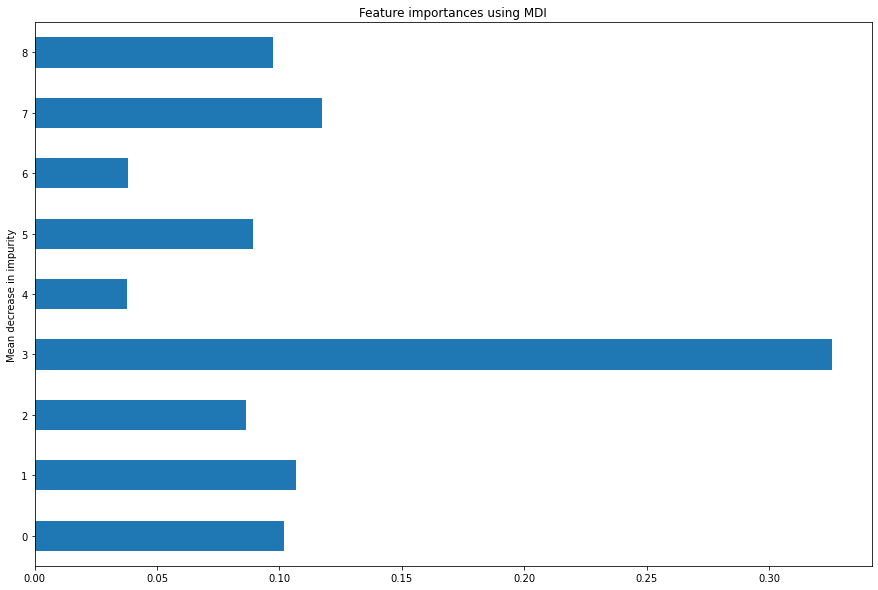

In [38]:
#Лучших параметров найти мы не смогли, вдобавок наша модель очевидно переучивается, попробуем пошаманить с препроцессингом
forest_importances = pd.Series(randomforest.feature_importances_)
fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(15, 10)
#Индексы важных параметров
imp_index = forest_importances[forest_importances > 0.03].index
display(imp_index)

In [39]:
#Отсеивание только важных переменных
res_df = pd.DataFrame(res_ct)
res_df = res_df.iloc[:,imp_index]
res_test_df = pd.DataFrame(res_test)
res_test_df = res_test_df.iloc[:,imp_index]
res_df.head()

,0,1,2,3,4,5,6,7,8
0,0.999968,0.000000,0.000456,0.007980,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.999998,0.001199,0.001799,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.049938,0.998752,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.000000,0.049938,0.998752,0.0,0.0,0.0,0.0,1.0


In [40]:
#randomforest = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, n_jobs = -1)
randomforest.fit(res_df, y_train)
y_pred4_2 = randomforest.predict(res_test_df)
balanced_accuracy_score(y_test, y_pred4_2)
print(balanced_accuracy_score(y_test, y_pred4_2))
print(accuracy_score(y_test, y_pred4_2))
print(confusion_matrix(y_test, y_pred4_2))
#В лучшую сторону не поменялось

0.6511660845504651
0.8267434420985285
[[5873   53]
 [1301  588]]


In [41]:
#Лучший рандомный лес
best_rf = make_pipeline(RandomForestClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, n_jobs = -1))

In [25]:
#Градиентный бустинг
gbc = GradientBoostingClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, min_samples_split = 5, learning_rate = 0.2)
gbc.fit(res_ct, y_train)
y_pred5 = gbc.predict(res_test)
print(balanced_accuracy_score(y_test, y_pred5))
print(accuracy_score(y_test, y_pred5))
print(roc_auc_score(y_test, y_pred5))
print(confusion_matrix(y_test, y_pred5))

0.7944119613936271
0.8689699296225208
0.7944119613936271
[[5563  363]
 [ 661 1228]]


In [45]:
#Тюнинг ГБ
cv=ShuffleSplit(n_splits=5,  test_size=0.3)
param_grid =[
     {'learning_rate': [0.001, 0.01, 0.1, 0.2,0.3]}
]

grid_gb = GridSearchCV(gbc,param_grid,cv=cv,scoring = 'balanced_accuracy',
                       return_train_score=True, error_score=0.0,verbose=10)
grid_gb.fit(res_ct,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid_gb.best_params_))
print("Лучший результат на кроссвалидации: {:.4f}\n".format(grid_gb.best_score_))
print("Тестовый: {:.4f}".format(grid_gb.score(res_test, y_test)))
gridresults_gb = pd.DataFrame(grid_gb.cv_results_)
display(gridresults_gb.sort_values(["rank_test_score"]).T)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START learning_rate=0.001.........................................
[CV 1/5; 1/5] END learning_rate=0.001;, score=(train=0.500, test=0.500) total time=  26.5s
[CV 2/5; 1/5] START learning_rate=0.001.........................................
[CV 2/5; 1/5] END learning_rate=0.001;, score=(train=0.500, test=0.500) total time=  24.6s
[CV 3/5; 1/5] START learning_rate=0.001.........................................
[CV 3/5; 1/5] END learning_rate=0.001;, score=(train=0.500, test=0.500) total time=  22.7s
[CV 4/5; 1/5] START learning_rate=0.001.........................................
[CV 4/5; 1/5] END learning_rate=0.001;, score=(train=0.500, test=0.500) total time=  24.2s
[CV 5/5; 1/5] START learning_rate=0.001.........................................
[CV 5/5; 1/5] END learning_rate=0.001;, score=(train=0.500, test=0.500) total time=  22.4s
[CV 1/5; 2/5] START learning_rate=0.01..........................................

,3,4,2,1,0
mean_fit_time,29.183097,37.62966,32.70722,27.622466,24.080123
std_fit_time,4.128568,12.689119,4.780147,2.660402,1.484351
mean_score_time,0.066216,0.12383,0.090022,0.125033,0.091822
std_score_time,0.005495,0.098989,0.019093,0.079198,0.008702
param_learning_rate,0.2,0.3,0.1,0.01,0.001
params,{'learning_rate': 0.2},{'learning_rate': 0.3},{'learning_rate': 0.1},{'learning_rate': 0.01},{'learning_rate': 0.001}
split0_test_score,0.79705,0.798646,0.795031,0.749678,0.5
split1_test_score,0.808546,0.802189,0.799768,0.763868,0.5
split2_test_score,0.792433,0.788129,0.790157,0.751086,0.5
split3_test_score,0.798453,0.796256,0.796595,0.751564,0.5


In [23]:
#Лучший ГБ
best_gb = make_pipeline(GradientBoostingClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, 
                                                learning_rate = 0.2, min_samples_split = 2, subsample = 1))

In [47]:
#Машина опорных векторов
svc = svm.SVC(kernel = 'linear', gamma = 'auto')
svc.fit(res_ct, y_train)
y_pred6 = svc.predict(res_test)
balanced_accuracy_score(y_test, y_pred6)
print(balanced_accuracy_score(y_test, y_pred6))
print(accuracy_score(y_test, y_pred6))
print(confusion_matrix(y_test, y_pred6))
#Хуже предыдущей

0.7525160766088623
0.8404350607805502
[[5468  458]
 [ 789 1100]]


In [48]:
#Тюнинг SVC
cv=ShuffleSplit(n_splits=5,  test_size=0.3)
param_grid =[
    {'C': [0.1,1,10,100]}
]

grid_svc = GridSearchCV(svc,param_grid,cv=cv,scoring = 'balanced_accuracy',
                       return_train_score=True, error_score=0.0,verbose=10)
grid_svc.fit(res_ct,y_train)

print("Словарь с параметрами для лучшего решения:\n{}\n".format(grid_svc.best_params_))
print("Лучший результат на кроссвалидации: {:.4f}\n".format(grid_svc.best_score_))
print("Тестовый: {:.4f}".format(grid_svc.score(res_test, y_test)))
gridresults_svc = pd.DataFrame(grid_svc.cv_results_)
display(gridresults_svc.sort_values(["rank_test_score"]).T)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=0.1.......................................................
[CV 1/5; 1/4] END ....C=0.1;, score=(train=0.752, test=0.750) total time=  20.3s
[CV 2/5; 1/4] START C=0.1.......................................................
[CV 2/5; 1/4] END ....C=0.1;, score=(train=0.754, test=0.760) total time=  15.3s
[CV 3/5; 1/4] START C=0.1.......................................................
[CV 3/5; 1/4] END ....C=0.1;, score=(train=0.762, test=0.754) total time=  15.4s
[CV 4/5; 1/4] START C=0.1.......................................................
[CV 4/5; 1/4] END ....C=0.1;, score=(train=0.756, test=0.762) total time=  15.0s
[CV 5/5; 1/4] START C=0.1.......................................................
[CV 5/5; 1/4] END ....C=0.1;, score=(train=0.754, test=0.753) total time=  24.8s
[CV 1/5; 2/4] START C=1.........................................................
[CV 1/5; 2/4] END ......C=1;, score=(train=0.759,

,3,2,1,0
mean_fit_time,44.970808,21.128077,19.205151,14.816662
std_fit_time,6.305981,3.333551,1.369182,3.305253
mean_score_time,2.908043,2.689712,3.348551,3.450104
std_score_time,0.390928,0.128269,0.337722,0.55771
param_C,100,10,1,0.1
params,{'C': 100},{'C': 10},{'C': 1},{'C': 0.1}
split0_test_score,0.755521,0.75587,0.758273,0.749775
split1_test_score,0.769164,0.767159,0.766558,0.760305
split2_test_score,0.762319,0.759889,0.760829,0.753832
split3_test_score,0.764105,0.765725,0.765623,0.761901


In [49]:
#Проверим крайний параметр C по сетке
svc1 = svm.SVC(kernel = 'linear', gamma = 0.1, C = 1000)
svc1.fit(res_ct, y_train)
y_pred6 = svc1.predict(res_test)
balanced_accuracy_score(y_test, y_pred6)
print(balanced_accuracy_score(y_test, y_pred6))
print(accuracy_score(y_test, y_pred6))
print(confusion_matrix(y_test, y_pred6))

0.7541654554754804
0.8418426103646833
[[5475  451]
 [ 785 1104]]


In [50]:
#Проверим параметр poly
svc2 = svm.SVC(kernel = 'poly', gamma = 0.1, C = 100)
svc2.fit(res_ct, y_train)
y_pred6 = svc2.predict(res_test)
balanced_accuracy_score(y_test, y_pred6)
print(balanced_accuracy_score(y_test, y_pred6))
print(accuracy_score(y_test, y_pred6))
print(confusion_matrix(y_test, y_pred6))
#Не лучше

0.7515696055122763
0.8354446577095329
[[5416  510]
 [ 776 1113]]


In [51]:
#Лучший SVM
best_svm = svm.SVC(C = 100, gamma = 'auto', kernel = 'linear')

0.7910471874130689
0.8696097248880358


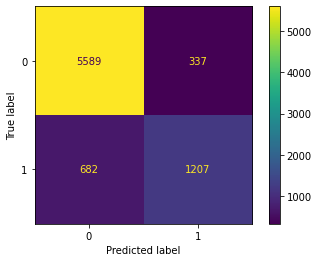

In [24]:
#Лучший ГБ
#best_gb = make_pipeline(GradientBoostingClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, 
#                                                learning_rate = 0.2, min_samples_split = 2, subsample = 1))
#Лучшая модель
gbc_best = GradientBoostingClassifier(n_estimators = 300, min_samples_leaf = 5, max_features=None, 
                                                learning_rate = 0.2, min_samples_split = 2, subsample = 1)
gbc_best.fit(res_ct, y_train)
y_pred7 = gbc_best.predict(res_test)
balanced_accuracy_score(y_test, y_pred7)
print(balanced_accuracy_score(y_test, y_pred7))
print(accuracy_score(y_test, y_pred7))
#print(confusion_matrix(y_test, y_pred7))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred7)).plot()

In [25]:
print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5926
           1       0.78      0.64      0.70      1889

    accuracy                           0.87      7815
   macro avg       0.84      0.79      0.81      7815
weighted avg       0.86      0.87      0.86      7815



Загрузка и обработка тестового файла

In [29]:
test = pd.read_csv('income_test.csv')
test.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,6513.000000,6.513000e+03,6513.000000,6513.000000,6513.000000,6513.000000
mean,38.614310,1.896839e+05,10.047904,1113.200368,81.934285,40.379395
std,13.716668,1.077012e+05,2.563118,7784.173117,390.304581,12.454632
min,17.000000,1.921400e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.159630e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.787800e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.362420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.184622e+06,16.000000,99999.000000,3683.000000,99.000000


In [30]:
display(test.isin(['?']).sum())

age                 0
workclass         335
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        337
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    115
dtype: int64

In [31]:
test['marital-status'] = test['marital-status'].map(marital_dict)
test.loc[test.workclass == 'Without-pay', 'occupation'] = 'Unemployed'
test.loc[test.workclass == 'Never-worked', 'occupation'] = 'Unemployed'
test.loc[test.workclass == '?', 'occupation'] = 'Unemployed'
test['native-country'] = test['native-country'].map(country_dict)
test['race'] = test['race'].map(racist_dict)
test.drop(columns = ['fnlwgt', 'education'], inplace = True)
display(test.isna().sum())
test.head()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,43,Private,10,Married,Handlers-cleaners,Husband,1,Male,0,0,40,2
1,58,Private,10,Married,Exec-managerial,Husband,1,Male,0,0,40,2
2,37,Self-emp-inc,11,Married,Sales,Husband,1,Male,0,0,40,2
3,42,Private,7,Married,Other-service,Wife,1,Female,0,0,40,2
4,40,Self-emp-not-inc,9,Married,Craft-repair,Husband,1,Male,0,1672,40,2


Выбираем лучшую ГБ модель (наивысшая точность 0.78), трансформируем X и обучаем модель 

In [32]:
#Трансформация и обучение
testX = CT.transform(test)
X_total = CT.transform(X)
best_gb.fit(X_total, y)
y_predicted = best_gb.predict(testX)
y_predicted

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
#Количество чего напрогнозировали
unique, counts = np.unique(y_predicted, return_counts=True)
dict(zip(unique, counts))

{0: 5230, 1: 1283}

In [60]:
#? не дропал, для меня они безработные
#Прогнать по y_test_new - вашим y
#y_test_new.replace('<=50K', 0, inplace = True)
#y_test_new.replace('>50K', 1, inplace = True)